
Multi-Modal Breast Cancer Classification using EfficientNet and Tabular Features
================================================================================
This implementation combines image features (from mammograms) with tabular clinical data
for improved breast cancer detection using a multi-modal deep learning approach.

Architecture:
- Image Encoder: EfficientNet-B0 (pretrained, with selective fine-tuning)
- Tabular Encoder: 3-layer fully connected network with batch normalization
- Fusion: Concatenation with optional attention mechanism
- Classifier: 3-layer MLP with dropout regularization

Dataset: Mini-DDSM (Digital Database for Screening Mammography)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import zipfile
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


### Kaggle Authentication and Dataset Download
Run these cells to authenticate with Kaggle and download the Mini-DDSM dataset


In [3]:
from google.colab import files


uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [4]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d cheddad/miniddsm

zip_path = "miniddsm.zip"
extract_dir = "mini_ddsm"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete. Files are now in", extract_dir)


Dataset URL: https://www.kaggle.com/datasets/cheddad/miniddsm
License(s): copyright-authors
 93% 395M/427M [00:00<00:00, 530MB/s]
100% 427M/427M [00:00<00:00, 561MB/s]
Extraction complete. Files are now in mini_ddsm


### Dataset Structure and Metadata Processing

The Mini-DDSM dataset contains:
- Benign cases: Non-cancerous abnormalities
- Cancer cases: Malignant tumors
- Normal cases: Healthy tissue

We process the Excel files and create a unified metadata CSV with:
- Image paths
- Patient age
- Breast density (1-4 scale, 4 being most dense)
- Family history (simulated for demonstration)
- Binary labels (0: Benign/Normal, 1: Cancer)


In [5]:

def prepare_metadata():
    base_dir = "mini_ddsm/Mini_DDSM_Upload"

    # Load Excel files for each category
    benign_excel = os.path.join(base_dir, "List_Benign.xlsx")
    cancer_excel = os.path.join(base_dir, "List_Cancer.xlsx")
    normal_excel = os.path.join(base_dir, "List_Normal.xlsx")

    df_benign = pd.read_excel(benign_excel)
    df_cancer = pd.read_excel(cancer_excel)
    df_normal = pd.read_excel(normal_excel)

    # Add folder information
    df_benign['folder'] = 'Benign'
    df_cancer['folder'] = 'Cancer'
    df_normal['folder'] = 'Normal'

    # Combine all dataframes
    combined = pd.concat([df_benign, df_cancer, df_normal], ignore_index=True)

    # Create binary labels: 0 for Benign/Normal, 1 for Cancer
    label_map = {'Benign': 0, 'Cancer': 1, 'Normal': 0}
    combined['label'] = combined['folder'].map(label_map)

    # Handle missing density values (default to 3)
    combined["density"] = combined["Density"].fillna(3)

    # Simulate family history for demonstration (in practice, use real data)
    random.seed(42)
    combined["family_history"] = [random.randint(0, 1) for _ in range(len(combined))]

    # Create full image paths
    combined["image_path"] = combined.apply(
        lambda row: os.path.join(base_dir, row["folder"], str(row["fileName"])),
        axis=1
    )

    # Select and rename final columns
    final_df = combined[["image_path", "Age", "density", "family_history", "label"]]
    final_df = final_df.rename(columns={"Age": "age"})

    # Clean data
    final_df = final_df.dropna(subset=['label'])
    final_df['label'] = final_df['label'].astype(int)

    return final_df

# Prepare metadata
final_df = prepare_metadata()
final_df.to_csv("metadata.csv", index=False)

print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total samples: {len(final_df)}")
print(f"\nLabel distribution:")
print(final_df['label'].value_counts())
print(f"\nClass balance: {final_df['label'].value_counts()[1] / len(final_df) * 100:.2f}% positive")
print(f"Average age: {final_df['age'].mean():.1f} ± {final_df['age'].std():.1f}")
print(f"Average density: {final_df['density'].mean():.1f} ± {final_df['density'].std():.1f}")


DATASET STATISTICS
Total samples: 9684

Label distribution:
label
0    6088
1    3596
Name: count, dtype: int64

Class balance: 37.13% positive
Average age: 57.5 ± 12.7
Average density: 2.6 ± 1.0


In [ ]:

# base_dir = "mini_ddsm/Mini_DDSM_Upload"

# benign_excel = os.path.join(base_dir, "List_Benign.xlsx")
# cancer_excel = os.path.join(base_dir, "List_Cancer.xlsx")
# normal_excel = os.path.join(base_dir, "List_Normal.xlsx")

# df_benign = pd.read_excel(benign_excel)
# df_cancer = pd.read_excel(cancer_excel)
# df_normal = pd.read_excel(normal_excel)


# df_benign['folder'] = 'Benign'
# df_cancer['folder'] = 'Cancer'
# df_normal['folder'] = 'Normal'

# combined = pd.concat([df_benign, df_cancer, df_normal], ignore_index=True)

# label_map = {'Benign': 0, 'Cancer': 1, 'Normal': 0}
# combined['label'] = combined['folder'].map(label_map)

# combined["density"] = combined["Density"].fillna(3)

# random.seed(42)
# combined["family_history"] = [random.randint(0, 1) for _ in range(len(combined))]

# combined["image_path"] = combined.apply(
#     lambda row: os.path.join(base_dir, row["folder"], str(row["fileName"])),
#     axis=1
# )

# final_df = combined[["image_path", "Age", "density", "family_history", "label"]]
# final_df = final_df.rename(columns={"Age": "age"})

# final_df = final_df.dropna(subset=['label'])

# final_df['label'] = final_df['label'].astype(int)

# final_df.to_csv("metadata.csv", index=False)
# print("metadata.csv created successfully!")
# print(f"Dataset size: {len(final_df)} samples")
# print(f"Label distribution:\n{final_df['label'].value_counts()}")
# print(f"Class balance: {final_df['label'].value_counts()[1] / len(final_df) * 100:.2f}% positive")



    PyTorch Dataset for multi-modal breast cancer classification.
    
    Handles:
    - Image loading and preprocessing
    - Tabular feature normalization
    - Optional MixUp augmentation for training
    
    Args:
        csv_file (str): Path to metadata CSV file
        transform (torchvision.transforms): Image transformations
        is_training (bool): Whether dataset is for training
        mixup_alpha (float): MixUp augmentation parameter
  

In [6]:
class MultiModalDataset(Dataset):


    def __init__(self, csv_file, transform=None, is_training=True, mixup_alpha=0.2):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.is_training = is_training
        self.mixup_alpha = mixup_alpha

        # Normalize tabular features
        self.scaler = StandardScaler()
        tabular_features = ['age', 'density', 'family_history']
        self.data[tabular_features] = self.scaler.fit_transform(self.data[tabular_features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Load and transform image
        try:
            img = Image.open(row["image_path"]).convert('RGB')
            if self.transform:
                image = self.transform(img)
        except Exception as e:
            print(f"Error loading image at {row['image_path']}: {e}")
            # Return zero tensor as fallback
            image = torch.zeros(3, 224, 224)

        # Extract tabular features
        tab = torch.tensor(
            [row["age"], row["density"], row["family_history"]],
            dtype=torch.float32
        )

        # Get label
        label = torch.tensor(row["label"], dtype=torch.float32)

        return image, tab, label


### Image Augmentation Strategies

Training augmentations:
- Spatial: Random cropping, flipping, rotation, affine transformations
- Color: Brightness, contrast, saturation, hue adjustments
- Regularization: Random erasing (cutout)

Validation augmentations:
- Only resize and normalization (no random augmentations)


In [7]:
transform_train = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    # T.RandomVerticalFlip(p=0.3),  # Uncomment if anatomically appropriate
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0.1),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # T.RandomGrayscale(p=0.1),  # Uncomment for additional augmentation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    T.RandomErasing(p=0.2, scale=(0.02, 0.2))  # Cutout augmentation
])

# Validation augmentations - deterministic
transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


    Multi-Modal Neural Network for Breast Cancer Classification.
    
    Architecture:
    1. Image Encoder: Pretrained EfficientNet-B0 with selective fine-tuning
    2. Tabular Encoder: 3-layer MLP with batch normalization
    3. Feature Fusion: Concatenation with optional multi-head attention
    4. Classifier: 3-layer MLP with heavy dropout
    
    Args:
        tabular_features (int): Number of tabular input features
        dropout_rate (float): Dropout probability for regularization
        use_attention (bool): Whether to use attention mechanism for fusion
    

In [8]:
class MultiModalNet(nn.Module):


    def __init__(self, tabular_features=3, dropout_rate=0.5, use_attention=True):
        super().__init__()

        # ===== Image Encoder =====
        # Use pretrained EfficientNet-B0 for efficient feature extraction
        self.img_encoder = timm.create_model("efficientnet_b0", pretrained=True)

        # Selective fine-tuning: freeze early layers, train only last 2 blocks
        for name, param in self.img_encoder.named_parameters():
            if 'blocks.6' not in name and 'blocks.7' not in name and 'classifier' not in name:
                param.requires_grad = False

        # Get feature dimension and replace classifier with identity
        img_features = self.img_encoder.classifier.in_features  # 1280 for EfficientNet-B0
        self.img_encoder.classifier = nn.Identity()

        # ===== Tabular Encoder =====
        # Multi-layer perceptron for tabular features
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # ===== Feature Fusion with Attention =====
        self.use_attention = use_attention
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=img_features + 32,
                num_heads=4,
                dropout=dropout_rate
            )

        # ===== Final Classifier =====
        self.classifier = nn.Sequential(
            nn.Linear(img_features + 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 1.2),  # Higher dropout in classifier

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(32, 1)  # Binary classification
        )

    def forward(self, img, tab):
        """
        Forward pass through the multi-modal network.

        Args:
            img: Batch of images (B, 3, 224, 224)
            tab: Batch of tabular features (B, 3)

        Returns:
            Logits for binary classification (B, 1)
        """
        # Extract features from both modalities
        img_feat = self.img_encoder(img)  # (B, 1280)
        tab_feat = self.tabular_fc(tab)   # (B, 32)

        # Concatenate features
        x = torch.cat([img_feat, tab_feat], dim=1)  # (B, 1312)

        # Apply attention if enabled
        if self.use_attention:
            x = x.unsqueeze(0)  # (1, B, 1312) for attention
            x, _ = self.attention(x, x, x)
            x = x.squeeze(0)    # (B, 1312)

        # Final classification
        return self.classifier(x)


In [9]:
class LabelSmoothingBCELoss(nn.Module):

    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        # Apply label smoothing
        target = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return F.binary_cross_entropy_with_logits(pred, target)


In [14]:
class EarlyStopping:

    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

In [10]:
dataset = MultiModalDataset("metadata.csv", transform=transform_train, is_training=True)

# Create stratified train/validation split
indices = list(range(len(dataset)))
labels = dataset.data['label'].values

train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create subset datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Apply validation transforms to validation dataset
val_dataset.dataset.transform = transform_val
val_dataset.dataset.is_training = False

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nDataLoader Statistics:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



DataLoader Statistics:
Training batches: 243
Validation batches: 61
Training samples: 7747
Validation samples: 1937


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize model
model = MultiModalNet(dropout_rate=0.5, use_attention=True).to(device)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,           # Small learning rate for pretrained model
    weight_decay=1e-3  # L2 regularization
)

# Loss function with label smoothing
criterion = LabelSmoothingBCELoss(smoothing=0.1)

# Learning rate scheduler: Cosine annealing with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,    # Initial restart period
    T_mult=2   # Period doubling factor
)




Using device: cuda
GPU: Tesla T4


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Model Statistics:
Total parameters: 11,077,533
Trainable parameters: 7,787,217
Frozen parameters: 3,290,316


In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (imgs, tabs, labels) in enumerate(dataloader):
        # Move to device
        imgs = imgs.to(device)
        tabs = tabs.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(imgs, tabs)
        loss = criterion(outputs, labels)

        # Add L2 regularization on activations
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):

    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for imgs, tabs, labels in dataloader:
            # Move to device
            imgs = imgs.to(device)
            tabs = tabs.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(imgs, tabs)
            loss = criterion(outputs, labels)

            # Track metrics
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store for metrics calculation
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    # Calculate additional metrics
    f1 = f1_score(all_labels, all_preds, average='binary')
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.5

    return avg_loss, accuracy, f1, auc, all_preds, all_labels, all_probs


In [15]:

num_epochs = 100
early_stopping = EarlyStopping(patience=20)
best_val_acc = 0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_f1': [], 'val_auc': []
}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc, val_f1, val_auc, _, _, _ = validate_epoch(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_auc': val_auc
        }, 'best_model.pth')

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"\nEpoch [{epoch+1}/{num_epochs}] (LR: {current_lr:.6f})")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  Metrics - F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"  Generalization Gap: {train_acc - val_acc:.2f}%")

    # Early stopping check
    if early_stopping(val_loss):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break


STARTING TRAINING

Epoch [1/100] (LR: 0.000049)
  Train - Loss: 139.9287, Acc: 47.14%
  Val   - Loss: 0.6650, Acc: 60.82%
  Metrics - F1: 0.5990, AUC: 0.7210
  Generalization Gap: -13.67%

Epoch [5/100] (LR: 0.000025)
  Train - Loss: 137.1403, Acc: 70.57%
  Val   - Loss: 0.5771, Acc: 74.81%
  Metrics - F1: 0.6676, AUC: 0.8144
  Generalization Gap: -4.24%

Epoch [10/100] (LR: 0.000050)
  Train - Loss: 136.4129, Acc: 76.66%
  Val   - Loss: 0.5531, Acc: 77.75%
  Metrics - F1: 0.6796, AUC: 0.8354
  Generalization Gap: -1.09%

Epoch [15/100] (LR: 0.000043)
  Train - Loss: 134.8493, Acc: 84.78%
  Val   - Loss: 0.5119, Acc: 78.37%
  Metrics - F1: 0.6894, AUC: 0.8571
  Generalization Gap: 6.41%

Epoch [20/100] (LR: 0.000025)
  Train - Loss: 133.8249, Acc: 91.51%
  Val   - Loss: 0.5173, Acc: 78.21%
  Metrics - F1: 0.7235, AUC: 0.8613
  Generalization Gap: 13.29%

Epoch [25/100] (LR: 0.000007)
  Train - Loss: 133.3567, Acc: 93.60%
  Val   - Loss: 0.5072, Acc: 79.92%
  Metrics - F1: 0.7227, AUC:


LOADING BEST MODEL FOR FINAL EVALUATION
Loaded model from epoch 35
Best validation accuracy: 80.80%

FINAL RESULTS (Best Model)
Validation Accuracy: 80.80%
Validation F1 Score: 0.7130
Validation AUC: 0.8724
Training-Validation Gap: 13.25%

Confusion Matrix:
[[1103  115]
 [ 257  462]]
  True Negatives:  1103
  False Positives: 115
  False Negatives: 257
  True Positives:  462

Classification Report:
               precision    recall  f1-score   support

Benign/Normal     0.8110    0.9056    0.8557      1218
       Cancer     0.8007    0.6426    0.7130       719

     accuracy                         0.8080      1937
    macro avg     0.8059    0.7741    0.7843      1937
 weighted avg     0.8072    0.8080    0.8027      1937



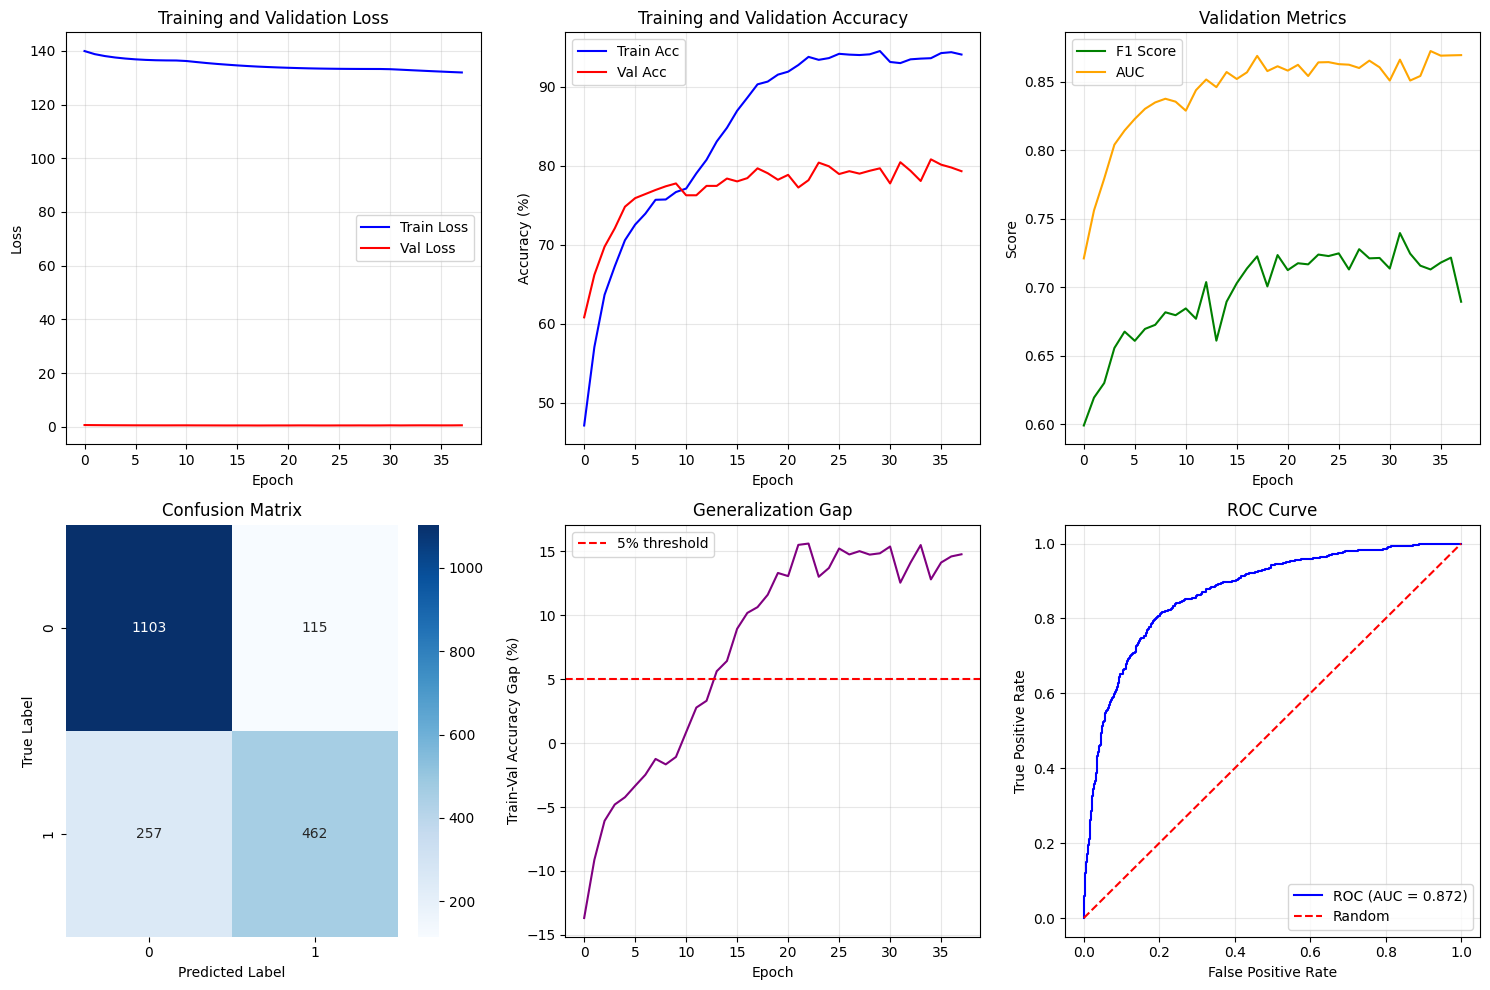


Training completed! Results saved to 'comprehensive_results.png'
Best model saved with 80.80% validation accuracy


In [17]:
# Load best model
print("\n" + "="*60)
print("LOADING BEST MODEL FOR FINAL EVALUATION")
print("="*60)

checkpoint = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Final evaluation
_, final_acc, final_f1, final_auc, all_preds, all_labels, all_probs = validate_epoch(
    model, val_loader, criterion, device
)

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print comprehensive results
print("\n" + "="*60)
print("FINAL RESULTS (Best Model)")
print("="*60)
print(f"Validation Accuracy: {final_acc:.2f}%")
print(f"Validation F1 Score: {final_f1:.4f}")
print(f"Validation AUC: {final_auc:.4f}")
print(f"Training-Validation Gap: {history['train_acc'][-1] - final_acc:.2f}%")

print("\nConfusion Matrix:")
print(cm)
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=['Benign/Normal', 'Cancer'],
                          digits=4))

# Plot comprehensive results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 and AUC curves
axes[0, 2].plot(history['val_f1'], label='F1 Score', color='green')
axes[0, 2].plot(history['val_auc'], label='AUC', color='orange')
axes[0, 2].set_title('Validation Metrics')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Score')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Training-Validation Gap
gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
axes[1, 1].plot(gap, color='purple')
axes[1, 1].axhline(y=5, color='r', linestyle='--', label='5% threshold')
axes[1, 1].set_title('Generalization Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Train-Val Accuracy Gap (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1, 2].plot(fpr, tpr, color='blue', label=f'ROC (AUC = {final_auc:.3f})')
axes[1, 2].plot([0, 1], [0, 1], 'r--', label='Random')
axes[1, 2].set_title('ROC Curve')
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_results.png', dpi=150)
plt.show()

print("\nTraining completed! Results saved to 'comprehensive_results.png'")
print(f"Best model saved with {best_val_acc:.2f}% validation accuracy")